<a href="https://colab.research.google.com/github/Nikhil-Khetani/Tesla-Stock-Price-Predictor/blob/main/Notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler


style.use('ggplot')

num_epochs = 100
input_length = 10
batch_size = 16


start = datetime(2011, 1, 1)
end = datetime(2021, 1, 1)

df = web.DataReader('TSLA', 'yahoo', start, end).reset_index(level=0)
'''
df.to_csv('tsla.csv')

df = pd.read_csv('tsla.csv', index_col=0).reset_index()
'''
df.head()


,Date,High,Low,Open,Close,Volume,Adj Close
0,2011-01-03,5.400,5.180,5.368,5.324,6415000.0,5.324
1,2011-01-04,5.390,5.204,5.332,5.334,5937000.0,5.334
2,2011-01-05,5.380,5.238,5.296,5.366,7233500.0,5.366
3,2011-01-06,5.600,5.362,5.366,5.576,10306000.0,5.576
4,2011-01-07,5.716,5.580,5.600,5.648,11239500.0,5.648


In [2]:
df = pd.DataFrame(df[['Date','Adj Close']])
df['Date']=pd.to_datetime(df['Date'])
df.head()

,Date,Adj Close
0,2011-01-03,5.324
1,2011-01-04,5.334
2,2011-01-05,5.366
3,2011-01-06,5.576
4,2011-01-07,5.648


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2517 non-null   datetime64[ns]
 1   Adj Close  2517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [4]:
df.set_index('Date', inplace=True)

In [5]:
df['2015'].head()

,Adj Close
Date,
2015-01-02,43.862000
2015-01-05,42.018002
2015-01-06,42.256001
2015-01-07,42.189999
2015-01-08,42.124001


In [6]:
date_range = df.index.max()-df.index.min()
print(date_range)

3650 days 00:00:00


In [7]:
new_index = pd.date_range(df.index.min(),df.index.max())
df = df.reindex(new_index)

In [8]:
df['Adj Close'].value_counts(dropna=False)

NaN          1134
5.484000        4
42.018002       3
5.424000        3
6.492000        3
             ... 
56.366001       1
48.292000       1
42.888000       1
39.209999       1
49.548000       1
Name: Adj Close, Length: 2354, dtype: int64

In [9]:
df['Adj Close'].interpolate(method='linear', inplace=True)

In [10]:
df['Adj Close'].value_counts(dropna=False)


5.484000     4
5.634000     3
6.492000     3
5.320000     3
42.018002    3
            ..
45.557999    1
4.748500     1
34.335499    1
25.804000    1
6.750000     1
Name: Adj Close, Length: 3471, dtype: int64

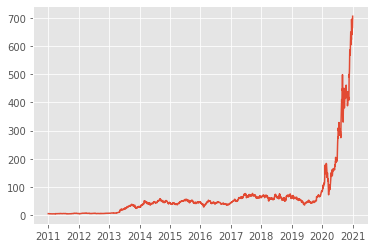

In [11]:
plt.plot(df)

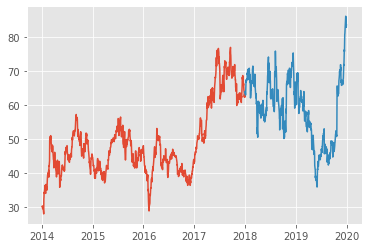

In [12]:
train_data = pd.DataFrame(df['2014':'2017'])
test_data = df['2018':'2019']

plt.plot(train_data)
plt.plot(test_data)

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_scaled = scaler.fit_transform(train_data)

In [14]:
train_data['Scaled_close'] = train_data_scaled
train_data = pd.DataFrame(train_data['Scaled_close'])
train_data

,Scaled_close
2014-01-01,-0.911056
2014-01-02,-0.912399
2014-01-03,-0.916796
2014-01-04,-0.923743
2014-01-05,-0.930690
...,...
2017-12-27,0.402752
2017-12-28,0.433037
2017-12-29,0.400391
2017-12-30,0.419075


In [15]:
train_data_lagged=train_data
for lag in range(1, input_length + 1):
            train_data_lagged['lag_' + str(lag)] = train_data_lagged[train_data_lagged.columns[0]].shift(lag)
            train_data_lagged.dropna(inplace=True)
train_data_lagged

,Scaled_close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
2014-02-25,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024,-0.487157,-0.498290,-0.509424
2014-02-26,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024,-0.487157,-0.498290
2014-02-27,-0.078401,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024,-0.487157
2014-02-28,-0.141333,-0.078401,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024
2014-03-01,-0.125729,-0.141333,-0.078401,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,0.402752,0.448750,0.464850,0.480949,0.497049,0.513148,0.565741,0.543922,0.561182,0.624440,0.636869
2017-12-28,0.433037,0.402752,0.448750,0.464850,0.480949,0.497049,0.513148,0.565741,0.543922,0.561182,0.624440
2017-12-29,0.400391,0.433037,0.402752,0.448750,0.464850,0.480949,0.497049,0.513148,0.565741,0.543922,0.561182
2017-12-30,0.419075,0.400391,0.433037,0.402752,0.448750,0.464850,0.480949,0.497049,0.513148,0.565741,0.543922


In [16]:
lag_features  = [i for i in reversed(train_data_lagged.columns) if i!='Scaled_close']
print(lag_features)
X_data = np.array(train_data_lagged[lag_features])
y_data = np.array(train_data_lagged['Scaled_close'])
X_data.shape

['lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6', 'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']


(1406, 10)

In [ ]:
for i in range(len(X_data)):
  print(X_data[i],y_data[i])


In [18]:
import tensorflow as tf

In [19]:
n_features = 1


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(input_length, n_features)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], n_features))

In [21]:
model.fit(X_data, y_data, epochs=200, verbose=1)

Epoch 1/200
44/44 [==============================] - 4s 16ms/step - loss: 0.1297
Epoch 2/200
44/44 [==============================] - 1s 16ms/step - loss: 0.0101
Epoch 3/200
44/44 [==============================] - 1s 18ms/step - loss: 0.0050
Epoch 4/200
16/44 [=========>....................] - ETA: 0s - loss: 0.0052

KeyboardInterrupt: ignored

In [22]:
train_data_lagged.head()

,Scaled_close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
2014-02-25,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024,-0.487157,-0.498290,-0.509424
2014-02-26,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024,-0.487157,-0.498290
2014-02-27,-0.078401,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024,-0.487157
2014-02-28,-0.141333,-0.078401,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926,-0.476024
2014-03-01,-0.125729,-0.141333,-0.078401,-0.074656,-0.115363,-0.362452,-0.384298,-0.406144,-0.427990,-0.424978,-0.557926


In [23]:
for i in range(20):
  print(model(np.expand_dims(X_data[i],0)).numpy(),y_data[i])

[[-0.4170128]] -0.1153627592159081
[[-0.34858403]] -0.07465609143844576
[[-0.2825712]] -0.07840106636363631
[[-0.22858772]] -0.14133347785061723
[[-0.19841471]] -0.1257292862593129
[[-0.16999722]] -0.11012509466800857
[[-0.14709984]] -0.09452090307670424
[[-0.1257804]] -0.059676036454070935
[[-0.10225631]] -0.07742402186269093
[[-0.08781385]] -0.07514445840530426
[[-0.07712311]] -0.12993566056368433
[[-0.08484204]] -0.14993619008080894
[[-0.09682064]] -0.16993671959793377
[[-0.11106932]] -0.18993724911505838
[[-0.12558262]] -0.2260034213638733
[[-0.14570156]] -0.16836276488376
[[-0.15083015]] -0.19848576736387225
[[-0.16132744]] -0.25400959761434705
[[-0.18252023]] -0.24584111013084042
[[-0.19809258]] -0.23767262264733358


In [24]:
# test_dates = pd.date_range(start=datetime(year=2015,month=1,day=2),periods=20)
# for i in test_dates:
  # print(i)

In [25]:
test_df = train_data['Scaled_close']['2015-01-01':'2015-01-10']
test_df

2015-01-01   -0.336319
2015-01-02   -0.348938
2015-01-03   -0.373959
2015-01-04   -0.398980
2015-01-05   -0.424001
2015-01-06   -0.414312
2015-01-07   -0.416999
2015-01-08   -0.419686
2015-01-09   -0.451925
2015-01-10   -0.464002
Freq: D, Name: Scaled_close, dtype: float64

In [31]:
test_input = np.array(test_df)
test_input

array([-0.33631853, -0.34893758, -0.37395858, -0.39897958, -0.42400059,
       -0.41431244, -0.41699916, -0.41968572, -0.4519254 , -0.4640017 ])

In [26]:
test_start_date = test_df.index.min()
test_start_date

Timestamp('2015-01-01 00:00:00', freq='D')

In [59]:
def predict(model, input_array, future_steps):
  seq_length = len(input_array)
  prediction = input_array
  for i in range(future_steps):
    input_seq = prediction[-seq_length:]
    model_output = model(np.expand_dims(np.expand_dims(input_seq,1),0)).numpy()[0]
    prediction = np.append(prediction, model_output)
  return prediction


In [71]:
pred = scaler.inverse_transform(np.expand_dims(predict(model, test_input, 100),0))[0]
pred

array([44.17199898, 43.86199951, 43.24733353, 42.63266754, 42.01800156,
       42.25600052, 42.18999863, 42.12400055, 41.33200073, 41.03533427,
       42.11965177, 42.08090924, 42.05081163, 42.03515956, 42.0476042 ,
       42.08559923, 42.10654456, 42.11874907, 42.1312391 , 42.17231125,
       42.22677614, 42.25096185, 42.27627064, 42.30302976, 42.33114918,
       42.359784  , 42.38783826, 42.41558868, 42.44363049, 42.4721965 ,
       42.500343  , 42.52759704, 42.55478007, 42.58187597, 42.60884595,
       42.63564608, 42.66223974, 42.68864086, 42.71485822, 42.74088302,
       42.76669258, 42.79228178, 42.81767183, 42.84285836, 42.86783549,
       42.89259666, 42.91716014, 42.94154646, 42.96572485, 42.98969385,
       43.013616  , 43.03755791, 43.06136511, 43.08503761, 43.10857173,
       43.13197333, 43.15524169, 43.17837315, 43.20135671, 43.22420776,
       43.24693069, 43.26951671, 43.2919585 , 43.31428096, 43.33647749,
       43.35852906, 43.3805206 , 43.40246015, 43.42431258, 43.44

In [72]:
pred_date_range = pd.date_range(test_start_date,periods=len(pred))
pred_df=pd.DataFrame(data={'Predictions':pred}, index=pred_date_range)
pred_df

,Predictions
2015-01-01,44.171999
2015-01-02,43.862000
2015-01-03,43.247334
2015-01-04,42.632668
2015-01-05,42.018002
...,...
2015-04-16,44.175765
2015-04-17,44.194825
2015-04-18,44.213812
2015-04-19,44.232734


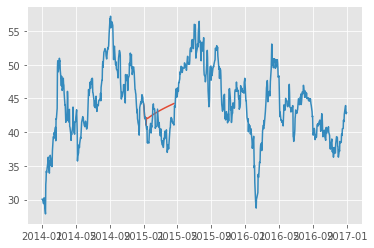

In [79]:
plt.plot(pred_df)
plt.plot(df['2014':'2016'])